# Predicting Mortality of Older US Adults Cross-validation and Feature Selection
## Author: Yiang Li
<ol>
<p>This is the a project for MACS 30100 Perspectives in Computational Modeling at the University of Chicago.</p>

The goal of this project is to train a binary classifier to predict the mortality of older US Adults in National Social and Health Survey (NSHAP) Wave 1 and Wave 3, which is a nationally representative survey of the older US adults (aged 57-85) in 2010 and 2020.

This project follows the preliminary analysis in project 1 that Zejian Lyv and I did and changes in the following ways:
    
1. I use merged the survey dataset with a network dataset to include the network measures as predictors.
2. I use a more comprehensive set of predictors, including allostatic load measures, health behaviors, socio-demographic status, and health status.
3. I use a model not based on trees: SVM

The link to the dataset: https://www.icpsr.umich.edu/web/NACDA/series/706

Present academic literature in predicting mortality has primarily focused on disease and frailty, although social, behavioral, and psychological statuses may herald broad physiological decline. We aim to predict mortality using a comprehensive set of predictors, including allostatic load measures, health behaviors, socio-demographic status, and health status. The findings of this study may help to identify older adults who are at risk of mortality and to develop interventions to improve their health.
We used the following models:

1. Decision tree
2. Random forest


We used 19 predictors:

1. Allostatic load measures: systolic blood pressure (continuous), body mass index (continuous), glycated hemoglobin (continuous), C-reactive protein (continuous), and hormone dehydroepiandrosterone (continuous)
* These measures were selected based on the following papers: <a href="https://academic.oup.com/psychsocgerontology/article/76/3/574/5703612">Peterson et al., 2021</a> and <a href="https://academic.oup.com/psychsocgerontology/article/64B/suppl_1/i67/552266">Williams et al., 2009</a>
2. Health behaviors: smoking (binary), alcohol consumption (binary), physical activity (binary), and sleep duration (ordinal)
* The measures were selected based on the following paper: <a href="https://www.jstor.org/stable/24759087">Nandi et al., 2014</a>
3. Socio-demographic status: age (ordinal), education (ordinal), net household assets (ordinal), marital status (binary), sex (binary), and race (binary)
* The measures were selected based on the following paper: <a href="https://doi.org/10.2307/2808154">Hummer et al., 1998</a>
4. Health status: self-rated physical (ordinal) and mental health (ordinal), chronic COPD conditions (binary), and functional limitations (binary)
* The measures were selected based on the following paper: <a href="https://doi.org/10.2105/AJPH.2007.130955">Lee et al., 2008</a>, <a href="https://doi.org/10.1111/j.1525-1497.2005.00291.x">DeSalvo et al., 2006</a>
  

In [2]:

import collections

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.tree as tree
from imblearn import over_sampling
from imblearn import under_sampling
from sklearn import ensemble
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

seed = 42

In [3]:
# Import full dataset
data_raw_full = pd.read_csv('nshap_w1_w2_w3_core_disposition.csv',
                            low_memory=False)
print(data_raw_full.shape)
# Since the raw full dataset has 2162 columns, we will only select the columns
# we need
data_raw_core = data_raw_full[['ID', 'w1WEIGHT_ADJ', 'w2DECEASED', 'w3DECEASED',
                               'w1SYSTOLIC_MEAN','w1BMI', 'w1HBA1C',
                               'w1CRP', 'w1DHEA_1', 'w1DHEA_2',
                               'w1SMOKECIG', 'w1ALCOHOL', 'w1PHYSACT', 
                               'w1HRSSLEEP', 'w1EDUC', 'w1HSASSETS_RECODE',
                               'w1MARITLST', 'w1ETHGRP', 'w1GENDER','w1PHYSHLTH',
                               'w1MNTLHLTH', 'w1CONDITNS_3', 'w1WALKBLK',
                               'w1AGEGRP', 'w1GENDER']]
# Display the first 5 rows of the dataset
data_raw_core.head(n=5)

(6069, 2162)


,ID,w1WEIGHT_ADJ,w2DECEASED,w3DECEASED,w1SYSTOLIC_MEAN,w1BMI,w1HBA1C,w1CRP,w1DHEA_1,w1DHEA_2,...,w1HSASSETS_RECODE,w1MARITLST,w1ETHGRP,w1GENDER,w1PHYSHLTH,w1MNTLHLTH,w1CONDITNS_3,w1WALKBLK,w1AGEGRP,w1GENDER
0,100005,0.846541,0.0,0.0,113.5,30.248745,5.5,11.746,19.400000,16.139999,...,4.0,1.0,1.0,2.0,4.0,4.0,0.0,0.0,1.0,2.0
1,100033,0.649874,0.0,0.0,114.0,44.103840,6.6,2.922,32.349998,36.209999,...,4.0,5.0,1.0,2.0,4.0,4.0,0.0,3.0,3.0,2.0
2,100067,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100080,1.193744,0.0,0.0,126.5,37.678516,7.3,0.552,19.990000,22.280001,...,5.0,1.0,1.0,1.0,3.0,5.0,0.0,0.0,1.0,1.0
4,100149,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
network_w1 = pd.read_csv('./nshap_w1_network.csv')
network_w1 = network_w1[['ID', 'RELAT', 'NODE_GENDER',
                         'LIVEWITH', 'TALKFREQ0', 'HOWCLOSE', 'SPCURRENT']]
display(network_w1.head(n=5))


,ID,RELAT,NODE_GENDER,LIVEWITH,TALKFREQ0,HOWCLOSE,SPCURRENT
0,100005,6,1,0,8,4,0
1,100005,1,1,1,8,2,1
2,100005,6,2,0,8,3,0
3,100005,4,2,0,6,3,0
4,100005,2,1,0,6,2,0


## Exploratory Data Analysis and Data Cleaning

Since the data contains original baseline cohort and follow-up cohort, we need to filter out the follow-up cohort without baseline observations. We also need to filter out missing values in the target variable (i.e., disposition).

In [4]:
network_w1 = network_w1.groupby('ID').head(5).reset_index(drop=True)
network_w1[network_w1 < 0] = np.nan
network_w1_trans = (network_w1.set_index(['ID',
                    network_w1.groupby(['ID']).cumcount().add(1)]).unstack()
                    .sort_index(axis=1, level=1))
network_w1_trans.columns = [f'{a}{b}' for a, b in network_w1_trans.columns]
network_w1_trans = network_w1_trans.reset_index()
display(network_w1_trans)

,ID,HOWCLOSE1,LIVEWITH1,NODE_GENDER1,RELAT1,SPCURRENT1,TALKFREQ01,HOWCLOSE2,LIVEWITH2,NODE_GENDER2,...,NODE_GENDER4,RELAT4,SPCURRENT4,TALKFREQ04,HOWCLOSE5,LIVEWITH5,NODE_GENDER5,RELAT5,SPCURRENT5,TALKFREQ05
0,100005,4.0,0.0,1.0,6.0,0.0,8.0,2.0,1.0,1.0,...,2.0,4.0,0.0,6.0,2.0,0.0,1.0,2.0,0.0,6.0
1,100033,4.0,0.0,2.0,6.0,0.0,8.0,4.0,0.0,2.0,...,2.0,11.0,0.0,7.0,NaN,1.0,1.0,9.0,0.0,NaN
2,100080,4.0,1.0,2.0,1.0,1.0,8.0,2.0,0.0,2.0,...,1.0,11.0,0.0,5.0,3.0,0.0,1.0,11.0,0.0,3.0
3,100154,3.0,1.0,1.0,1.0,1.0,8.0,3.0,0.0,2.0,...,2.0,10.0,0.0,8.0,2.0,0.0,1.0,6.0,0.0,6.0
4,100203,3.0,1.0,1.0,6.0,0.0,7.0,3.0,1.0,2.0,...,1.0,6.0,0.0,7.0,NaN,1.0,2.0,10.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2983,199753,3.0,1.0,1.0,1.0,1.0,8.0,4.0,0.0,2.0,...,2.0,12.0,0.0,7.0,4.0,0.0,2.0,11.0,0.0,6.0
2984,199776,2.0,1.0,2.0,3.0,1.0,8.0,2.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985,199814,3.0,0.0,2.0,11.0,0.0,7.0,4.0,0.0,2.0,...,2.0,9.0,0.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
2986,199879,4.0,1.0,1.0,1.0,1.0,8.0,3.0,0.0,2.0,...,1.0,6.0,0.0,6.0,3.0,1.0,1.0,6.0,0.0,8.0


Construct components of a scale of social network characteristics capturing social disconnectedness and social isolation. The scale is constructed based on the following paper: <a href="https://doi.org/10.1093/geronb/gbp037">Cornwell & Waite., 2017</a>

In [5]:
network_w1_trans['net_count'] = network_w1_trans[['LIVEWITH1', 'LIVEWITH2',
                                                  'LIVEWITH3', 'LIVEWITH4',
                                                  'LIVEWITH5']].count(axis=1)
network_w1_trans['num_unique'] = network_w1_trans[['RELAT1', 'RELAT2',
                                                   'RELAT3', 'RELAT4',
                                                   'RELAT5']].nunique(axis=1)
network_w1_trans['prop_live'] = network_w1_trans[['LIVEWITH1', 'LIVEWITH2',
                                                  'LIVEWITH3', 'LIVEWITH4',
                                                  'LIVEWITH5']].sum(axis=1)\
                                                /network_w1_trans['net_count']
talk_freq_col = ['TALKFREQ01', 'TALKFREQ02',
                 'TALKFREQ03', 'TALKFREQ04', 'TALKFREQ05']
network_w1_trans['avg_talk'] = 0
for i in talk_freq_col:
    network_w1_trans['avg_talk'] += np.where(network_w1_trans[i] == 8, 1, 0)
network_w1_trans['avg_talk'] /= network_w1_trans['net_count']
network_w1_trans['avg_close'] = network_w1_trans[['HOWCLOSE1', 'HOWCLOSE2',
                                                  'HOWCLOSE3', 'HOWCLOSE4',
                                                  'HOWCLOSE5']].sum(axis=1)\
                                                /network_w1_trans['net_count']
network_clean = network_w1_trans[['ID', 'net_count', 'num_unique',
                                  'prop_live', 'avg_talk', 'avg_close']]
display(network_clean)

,ID,net_count,num_unique,prop_live,avg_talk,avg_close
0,100005,5,4,0.2,0.6,2.80
1,100033,5,3,0.2,0.4,2.60
2,100080,5,3,0.2,0.2,2.80
3,100154,5,4,0.2,0.4,2.80
4,100203,5,2,0.6,0.2,2.40
...,...,...,...,...,...,...
2983,199753,5,4,0.2,0.6,3.60
2984,199776,2,2,0.5,0.5,2.00
2985,199814,4,4,0.0,0.5,3.75
2986,199879,5,3,0.4,0.4,3.20


In [6]:
# Merge the network data with the raw dataset for cleaning
data_raw = pd.merge(data_raw_core, network_clean, on='ID', how='left')

In [7]:
print("Total observations: {}\n".format(len(data_raw)))
# Remove follow-up respondents without W1 baseline observations,w1WEGIHT_ADJ is 
# the sampling weight when collecting W1 baseline data and 
# it is missing for follow-up respondents
data_w1 = data_raw[~data_raw['w1WEIGHT_ADJ'].isnull()]
print("Removed follow-up {} respondents without W1 baseline observations".format(len(data_raw) - len(data_w1)))
print("There are {} respondents with W1 baseline observations\n".format(len(data_w1)))

## Remove follow-up respondents without disposition statuses in W2 and W3

# Create a copy of dataframe of data_w1
data_decease = data_w1[data_w1.notnull()].copy()
# Create a new column 'deceased' to store disposition statuses with intial value
# being w3 disposition status
data_decease['deceased'] = data_decease['w3DECEASED']
# Set the value of missing w3 disposition status to nan (i.e., missing)
data_decease.loc[data_decease['deceased'] == -9, ['deceased']] = np.nan
# Replace the value of 'deceased' with w2 disposition status if w3 disposition
# is missing
data_decease['deceased'].fillna(data_decease['w2DECEASED'], inplace=True)
# Set the value of missing w2+w3 disposition status to nan
data_decease.loc[data_decease['deceased'] == -9, ['deceased']] = np.nan
# Remove follow-up respondents without disposition statuses
data_complete = data_decease[data_decease['deceased'].notnull()]
print("Removed follow-up {} respondents without disposition statuses\n".format(len(data_w1) - len(data_complete)))
print("Our sample frame has {} respondents".format(len(data_complete)))


Total observations: 6069

Removed follow-up 3064 respondents without W1 baseline observations
There are 3005 respondents with W1 baseline observations

Removed follow-up 10 respondents without disposition statuses

Our sample frame has 2995 respondents


We notice that the data is imbalanced. We will later use undersampling and oversampling methods to deal with this problem.

In [8]:
# Show the distribution of the binary target variable, disposition status, in 
# the sample frame
data_complete['deceased'].value_counts()

0.0    2102
1.0     893
Name: deceased, dtype: int64

In [9]:
# Create a new dataframe with only the variables we need 
# - W2 and W3 disposition status are removed
data = data_complete[['ID', 'deceased', 'w1WEIGHT_ADJ', 'w1AGE', 'w1SYSTOLIC_MEAN',
                      'w1BMI', 'w1HBA1C', 'w1CRP', 'w1DHEA_1', 'w1DHEA_2',
                      'w1SMOKECIG', 'w1ALCOHOL', 'w1PHYSACT', 'w1HRSSLEEP',
                      'w1EDUC', 'w1HSASSETS_RECODE', 'w1MARITLST', 'w1ETHGRP',
                      'w1GENDER',
                      'w1PHYSHLTH', 'w1MNTLHLTH', 'w1CONDITNS_3', 'w1WALKBLK',
                      'net_count', 'num_unique', 'prop_live', 'avg_talk', 'avg_close']]

In [10]:
# Show the first 5 rows of the dataframe
data.head(n=5)

,ID,deceased,w1WEIGHT_ADJ,w1AGE,w1SYSTOLIC_MEAN,w1BMI,w1HBA1C,w1CRP,w1DHEA_1,w1DHEA_2,...,w1GENDER,w1PHYSHLTH,w1MNTLHLTH,w1CONDITNS_3,w1WALKBLK,net_count,num_unique,prop_live,avg_talk,avg_close
0,100005,0.0,0.846541,62.0,113.500000,30.248745,5.5,11.746,19.400000,16.139999,...,2.0,4.0,4.0,0.0,0.0,5.0,4.0,0.2,0.6,2.8
1,100033,0.0,0.649874,79.0,114.000000,44.103840,6.6,2.922,32.349998,36.209999,...,2.0,4.0,4.0,0.0,3.0,5.0,3.0,0.2,0.4,2.6
3,100080,0.0,1.193744,60.0,126.500000,37.678516,7.3,0.552,19.990000,22.280001,...,1.0,3.0,5.0,0.0,0.0,5.0,3.0,0.2,0.2,2.8
5,100154,0.0,1.151208,78.0,176.000000,25.401367,5.7,0.499,27.510000,29.559999,...,2.0,3.0,3.0,0.0,0.0,5.0,4.0,0.2,0.4,2.8
7,100203,0.0,0.659711,61.0,137.666672,27.895041,-3.0,-3.000,57.250000,57.250000,...,2.0,1.0,2.0,0.0,1.0,5.0,2.0,0.6,0.2,2.4


In [11]:
# Preprocessing binary variables

# Create a list column names of binary variables
cat_col = ['ID', 'deceased', 'w1SMOKECIG', 'w1ALCOHOL', 'w1MARITLST',
           'w1ETHGRP', 'w1GENDER',
           'w1CONDITNS_3']
# Create a new dataframe with only binary variables
data_cat = data[data[cat_col].notnull()].copy()[cat_col]
# Code the 6-item categorical variable of martial status 
# (1=married, 2=living with a partner, 3=separated, 4=divorced, 
# 5=widowed, 6=never married) into binary
data_cat['w1married'] = np.where(data_cat['w1MARITLST'] == 1, 1, 0)
# Code the 4-item categorical variable of ethnicity 
# (1=white, 2=black, 3=hispanic, non-black, 4=other) into binary
data_cat['w1raceblk'] = np.where(data_cat['w1ETHGRP'] == 2, 1, 0)
# Drop the original 6-item and 4-item categorical variables
data_cat.drop('w1MARITLST', axis=1, inplace=True)
data_cat.drop('w1ETHGRP', axis=1, inplace=True)
# Convert the binary variables from text to categorical variables 
data_cat = data_cat.astype('category')
# Check the number of missing values in binary variable
data_cat_nona = data_cat.dropna()
print(
    "There are {} respondents with missing values in categorical variables".format(len(data_cat) - len(data_cat_nona)))

There are 0 respondents with missing values in categorical variables


In [12]:
# Preprocessing ordinal variables
# Create a list of column names of ordinal variables
ord_col = ['w1PHYSACT', 'w1EDUC', 'w1HSASSETS_RECODE',
           'w1PHYSHLTH', 'w1MNTLHLTH', 'w1WALKBLK']
# Create a new dataframe with only ordinal variables
data_ord = data[data[ord_col].notnull()].copy()[ord_col]
# Set values of missing ordinal variables originally coded as negative to nan
data_ord[data_ord < 0] = np.nan
# Check the number of missing values in original ordinal variables
data_ord_na = data_ord.dropna()
print("Fixed {} respondents with missing ordinal variables".format(len(data_ord) - len(data_ord_na)))
# Fill the missing values with the mean of the variable
data_ord.fillna(data_ord.mean(), inplace=True)
# Get the summary statistics of the ordinal variables
data_ord.describe()

Fixed 1155 respondents with missing ordinal variables


,w1PHYSACT,w1EDUC,w1HSASSETS_RECODE,w1PHYSHLTH,w1MNTLHLTH,w1WALKBLK
count,2995.000000,2995.000000,2995.000000,2995.000000,2995.000000,2995.000000
mean,3.113712,2.491486,3.649512,3.206504,3.718593,0.447896
std,1.358972,1.073537,1.007360,1.110284,0.987838,0.835975
min,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,3.000000,2.000000,3.649512,2.000000,3.000000,0.000000
50%,4.000000,3.000000,3.649512,3.000000,4.000000,0.000000
75%,4.000000,3.000000,4.000000,4.000000,4.000000,1.000000
max,4.000000,4.000000,5.000000,5.000000,5.000000,4.000000


In [13]:
# Preprocessing continuous variables
# Create a list of column names of continuous variables
con_col = ['w1WEIGHT_ADJ', 'w1AGE', 'w1SYSTOLIC_MEAN', 'w1BMI', 'w1HBA1C',
           'w1CRP', 'w1DHEA_1', 'w1DHEA_2', 'w1HRSSLEEP',
            'net_count', 'num_unique', 'prop_live', 'avg_talk', 'avg_close']
# Create a new dataframe with only continuous variables
data_con = data[data[con_col].notnull()].copy()[con_col]
# Convert the continuous variables from text to numeric variables
for col in con_col:
    data_con[col] = pd.to_numeric(data_con[col], errors='coerce')
# Get the mean of the two DHEA measurements
data_con['w1dhea_mean'] = data_con[['w1DHEA_1', 'w1DHEA_2']].mean(axis=1)
# Drop the original two DHEA measurements
data_con = data_con.drop(['w1DHEA_1', 'w1DHEA_2'], axis=1)
# Set values of missing continuous variables originally coded as negative to nan
data_con[data_con < 0] = np.nan
# Check the number of missing values in original continuous variables
data_con_na = data_con.dropna()
print("Fixed {} respondents with missing ordinal variables".format(len(data_con) - len(data_con_na)))
# Fill the missing values with the mean of the variable
data_con.fillna(data_con.mean(), inplace=True)
# Get the summary statistics of the continuous variables
data_con.describe()

Fixed 1563 respondents with missing ordinal variables


,w1WEIGHT_ADJ,w1AGE,w1SYSTOLIC_MEAN,w1BMI,w1HBA1C,w1CRP,w1HRSSLEEP,net_count,num_unique,prop_live,avg_talk,avg_close,w1dhea_mean
count,2995.000000,2995.000000,2995.000000,2995.000000,2995.000000,2995.000000,2995.000000,2995.000000,2995.000000,2995.000000,2995.000000,2995.000000,2995.000000
mean,1.000914,69.307513,137.138234,29.095167,6.097641,3.194580,6.888366,3.977502,2.765615,0.250235,0.395204,3.002149,52.921454
std,0.652064,7.857698,20.306078,6.078190,0.782456,4.848129,1.381350,1.243486,0.980505,0.258467,0.281386,0.623163,109.835482
min,0.149840,57.000000,78.000000,14.063041,4.200000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.510000
25%,0.610117,62.000000,122.500000,25.101870,5.700000,1.053500,6.000000,3.000000,2.000000,0.000000,0.200000,2.666667,22.252500
50%,0.846541,69.000000,135.666672,28.793165,6.097641,3.194580,7.000000,5.000000,3.000000,0.200000,0.333333,3.000000,46.205000
75%,1.233965,76.000000,149.000000,31.773318,6.097641,3.194580,8.000000,5.000000,3.000000,0.333333,0.500000,3.400000,53.247500
max,11.354286,85.000000,233.000000,75.600655,14.200000,100.000000,13.000000,5.000000,5.000000,2.000000,1.000000,4.000000,5000.000000


In [14]:
# Combine the three dataframes of binary, ordinal, and continuous var into one
datanona = pd.concat([data_cat, data_ord, data_con], axis=1)

#### Notes on outliers, standardization, and normalization
Below we see the distribution of the continuous variables. We observe that the variables are mostly normally distributed with few outliers. This might reflect the representation of the US population health status and we will not remove the outliers. We also notice that the variables are on different scales. We do not normalize or standardize the data because 1) we will use tree-based methods that are not sensitive to the scale of the data; 2) the scale of the data has practical meaning (e.g., systolic mean reflects the blood pressure of the respondent and the exact value has medical meanings) and we do not want to lose this information.

array([[<AxesSubplot: title={'center': 'w1WEIGHT_ADJ'}>,
        <AxesSubplot: title={'center': 'w1AGE'}>,
        <AxesSubplot: title={'center': 'w1SYSTOLIC_MEAN'}>,
        <AxesSubplot: title={'center': 'w1BMI'}>],
       [<AxesSubplot: title={'center': 'w1HBA1C'}>,
        <AxesSubplot: title={'center': 'w1CRP'}>,
        <AxesSubplot: title={'center': 'w1HRSSLEEP'}>,
        <AxesSubplot: title={'center': 'net_count'}>],
       [<AxesSubplot: title={'center': 'num_unique'}>,
        <AxesSubplot: title={'center': 'prop_live'}>,
        <AxesSubplot: title={'center': 'avg_talk'}>,
        <AxesSubplot: title={'center': 'avg_close'}>],
       [<AxesSubplot: title={'center': 'w1dhea_mean'}>, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

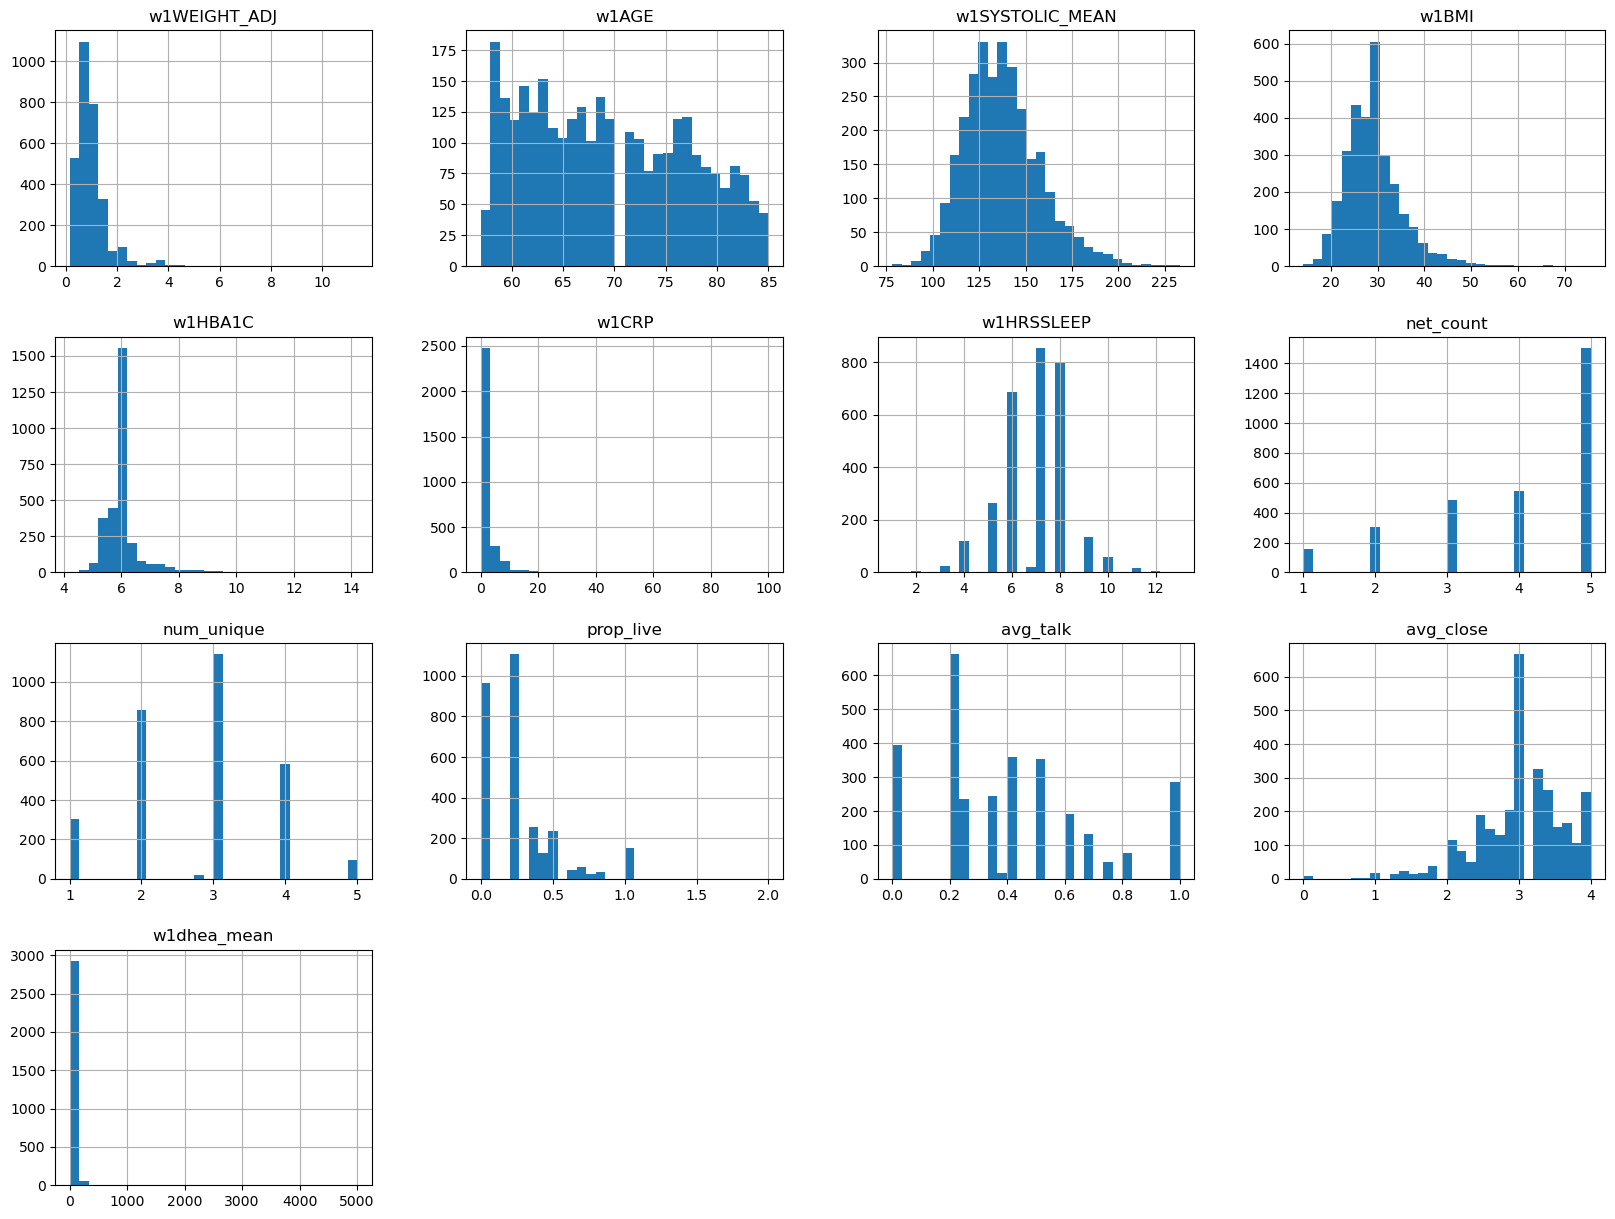

In [15]:
data_con.hist(bins=30, figsize=(20, 15))

#### Correlation matrix
When we look at the correlation matrix, we notice that the variables are not highly correlated (threshold of 0.8 as recommended by Hongkai and Dr Wang). This is good because it means that the variables are not redundant and we do not need to remove any of them.

Among the variables, we notice that the variables that are highly correlated with the target variable are: walking functionality, physical functionality and physical health. This is expected because these variables are related to the physical health status of the respondent. We also notice that the variables that are highly correlated with each other are: meatal health and physical health. This is expected because both variables reflect the overall self-rated health status of the respondent.

In [16]:
data_con

,w1WEIGHT_ADJ,w1AGE,w1SYSTOLIC_MEAN,w1BMI,w1HBA1C,w1CRP,w1HRSSLEEP,net_count,num_unique,prop_live,avg_talk,avg_close,w1dhea_mean
0,0.846541,62.0,113.500000,30.248745,5.500000,11.74600,6.0,5.0,4.0,0.20,0.60,2.80,17.770000
1,0.649874,79.0,114.000000,44.103840,6.600000,2.92200,5.0,5.0,3.0,0.20,0.40,2.60,34.279999
3,1.193744,60.0,126.500000,37.678516,7.300000,0.55200,5.0,5.0,3.0,0.20,0.20,2.80,21.135000
5,1.151208,78.0,176.000000,25.401367,5.700000,0.49900,5.0,5.0,4.0,0.20,0.40,2.80,28.535000
7,0.659711,61.0,137.666672,27.895041,6.097641,3.19458,7.0,5.0,2.0,0.60,0.20,2.40,57.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6050,0.289328,76.0,138.000000,29.626951,5.700000,0.93500,6.0,2.0,1.0,0.50,0.50,1.50,3.900000
6052,0.805225,61.0,115.000000,29.095167,6.300000,9.72400,7.0,4.0,4.0,0.25,0.75,2.75,52.921454
6057,0.556822,70.0,131.500000,24.638323,5.700000,2.56100,7.0,5.0,3.0,0.20,0.40,4.00,81.785004
6062,0.639700,83.0,142.500000,30.730789,5.400000,0.86000,6.0,4.0,4.0,0.00,0.50,3.75,19.320000


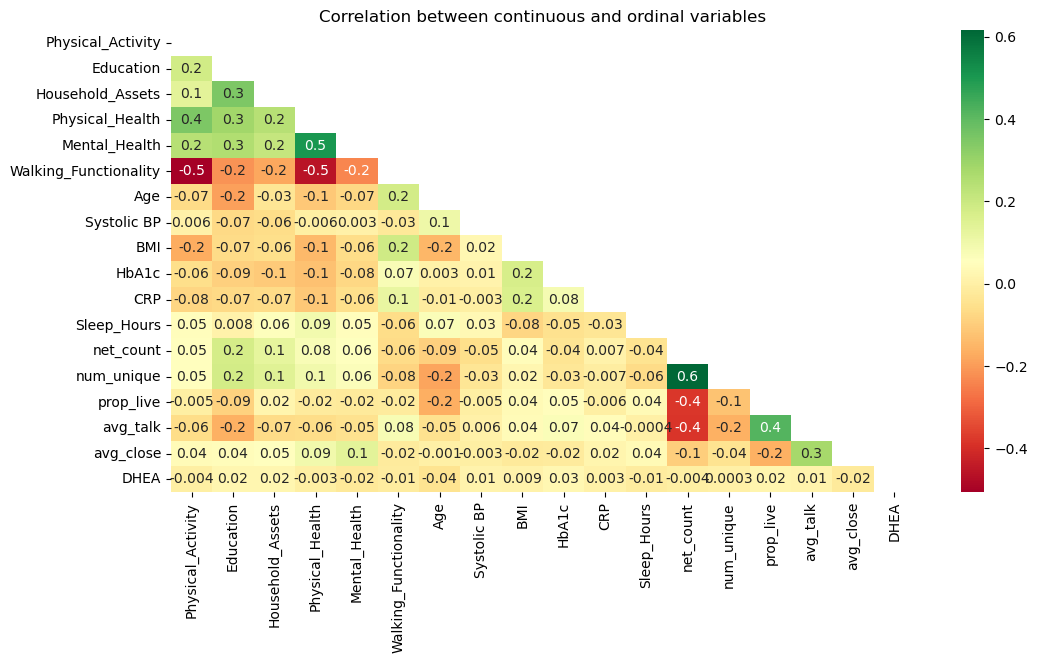

In [17]:
# Analyze the correlation amongst the continuous and ordinal variables
_, ax = plt.subplots(figsize=(12, 6))

# Combine the two dataframes of ordinal and continuous variables
data_ord_con = pd.concat([data_ord, data_con], axis=1)
data_ord_con = data_ord_con.drop(columns='w1WEIGHT_ADJ', inplace=False)
# Rename the columns of the combined dataframe
new_names = ['Physical_Activity', 'Education', 'Household_Assets',
             'Physical_Health', 'Mental_Health', 'Walking_Functionality',
             'Age', 'Systolic BP', 'BMI', 'HbA1c', 'CRP',
             'Sleep_Hours',
             'net_count', 'num_unique', 'prop_live', 'avg_talk', 'avg_close',
              'DHEA',]
# Assign the new names to the columns of the combined dataframe
data_ord_con.columns = new_names
# Create a mask to hide the upper triangle of the heatmap
matrix = np.triu(data_ord_con.corr())
# Plot the heatmap
sns.heatmap(data_ord_con.corr(), annot=True, fmt='.1g', cmap='RdYlGn', ax=ax,
            mask=matrix)
plt.title('Correlation between continuous and ordinal variables')
plt.show()

In [18]:
#First save the preprocessed data to .csv. Therefore, we can reload it without going through preprocessing again.

#datanona.to_csv('./save_df.csv', index=False)
data_nona = pd.read_csv('./save_df.csv')
seed = 42
data_nona

,ID,deceased,w1SMOKECIG,w1ALCOHOL,w1GENDER,w1CONDITNS_3,w1married,w1raceblk,w1PHYSACT,w1EDUC,...,w1MNTLHLTH,w1WALKBLK,w1WEIGHT_ADJ,w1AGE,w1SYSTOLIC_MEAN,w1BMI,w1HBA1C,w1CRP,w1HRSSLEEP,w1dhea_mean
0,100005,0.0,0.0,1.0,2.0,0.0,1,0,3.0,4.0,...,4.0,0.0,0.846541,62.0,113.500000,30.248745,5.500000,11.74600,6.0,17.770000
1,100033,0.0,0.0,1.0,2.0,0.0,0,0,4.0,3.0,...,4.0,3.0,0.649874,79.0,114.000000,44.103840,6.600000,2.92200,5.0,34.279999
2,100080,0.0,0.0,0.0,1.0,0.0,1,0,3.0,3.0,...,5.0,0.0,1.193744,60.0,126.500000,37.678516,7.300000,0.55200,5.0,21.135000
3,100154,0.0,0.0,1.0,2.0,0.0,1,0,0.0,2.0,...,3.0,0.0,1.151208,78.0,176.000000,25.401367,5.700000,0.49900,5.0,28.535000
4,100203,0.0,0.0,0.0,2.0,0.0,0,0,0.0,1.0,...,2.0,1.0,0.659711,61.0,137.666672,27.895041,6.097641,3.19458,7.0,57.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2990,199299,0.0,0.0,0.0,2.0,0.0,0,0,0.0,1.0,...,2.0,3.0,0.289328,76.0,138.000000,29.626951,5.700000,0.93500,6.0,3.900000
2991,199418,1.0,0.0,1.0,2.0,0.0,1,0,3.0,1.0,...,3.0,0.0,0.805225,61.0,115.000000,29.095167,6.300000,9.72400,7.0,52.921454
2992,199528,1.0,0.0,0.0,2.0,0.0,1,0,4.0,1.0,...,3.0,0.0,0.556822,70.0,131.500000,24.638323,5.700000,2.56100,7.0,81.785004
2993,199814,1.0,0.0,1.0,2.0,0.0,0,0,4.0,2.0,...,4.0,0.0,0.639700,83.0,142.500000,30.730789,5.400000,0.86000,6.0,19.320000


In [19]:
data_net = pd.merge(data_nona, network_clean, on="ID")
data_net.to_csv('./save_df_net.csv', index=False)